In [17]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load flux sequences
flux_sequences = np.load(r"C:\Users\Roshen Hasangha\Desktop\dataset\flux_sequences.npy", allow_pickle=True)
flux_kepler_ids = np.load(r"C:\Users\Roshen Hasangha\Desktop\dataset\flux_kepler_ids.npy")

merged_df = pd.read_csv(r"C:\Users\Roshen Hasangha\Desktop\dataset\final_multimodal_dataset.csv")

# Match sequences to labels
id_to_seq = {k: np.array(seq) for k, seq in zip(flux_kepler_ids, flux_sequences)}

matched_seqs, matched_labels = [], []
for _, row in merged_df.iterrows():
    kepler_id = row['Kepler_ID']
    if kepler_id in id_to_seq and len(id_to_seq[kepler_id]) == 512:
        matched_seqs.append(id_to_seq[kepler_id])
        matched_labels.append(row['label'])

X_seq = np.array(matched_seqs, dtype=np.float32)
y = np.array(matched_labels)

# Explicitly standardize sequences (important!)
scaler_seq = StandardScaler()
X_seq_scaled = scaler_seq.fit_transform(X_seq)

# Train-test split (80-20)
X_seq_train, X_seq_test, y_train, y_test = train_test_split(
    X_seq_scaled, y, test_size=0.2, random_state=42, stratify=y
)

print(f"✅ Data shape: Train {X_seq_train.shape}, Test {X_seq_test.shape}")


✅ Data shape: Train (1128, 512), Test (283, 512)


In [18]:
import tensorflow as tf

def build_transformer_only_model(seq_shape):
    seq_input = tf.keras.Input(shape=(seq_shape, 1))
    x = tf.keras.layers.LayerNormalization()(seq_input)
    x = tf.keras.layers.MultiHeadAttention(num_heads=2, key_dim=64)(x, x)
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(32, activation='relu')(x)
    output = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(inputs=seq_input, outputs=output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Build model
model_m2 = build_transformer_only_model(X_seq_train.shape[1])
model_m2.summary()


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 512, 1)]             0         []                            
                                                                                                  
 layer_normalization_2 (Lay  (None, 512, 1)               2         ['input_3[0][0]']             
 erNormalization)                                                                                 
                                                                                                  
 multi_head_attention_2 (Mu  (None, 512, 1)               897       ['layer_normalization_2[0][0]'
 ltiHeadAttention)                                                  , 'layer_normalization_2[0][0]
                                                                    ']                      

In [22]:
history_m2 = model_m2.fit(
    X_seq_train[..., np.newaxis], y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)]
)


Epoch 1/50
29/29 [==============================] - 5s 156ms/step - loss: 0.6874 - accuracy: 0.5721 - val_loss: 0.6922 - val_accuracy: 0.5221
Epoch 2/50
29/29 [==============================] - 5s 156ms/step - loss: 0.6869 - accuracy: 0.5721 - val_loss: 0.6922 - val_accuracy: 0.5221
Epoch 3/50
29/29 [==============================] - 5s 159ms/step - loss: 0.6864 - accuracy: 0.5721 - val_loss: 0.6923 - val_accuracy: 0.5221
Epoch 4/50
29/29 [==============================] - 5s 157ms/step - loss: 0.6860 - accuracy: 0.5721 - val_loss: 0.6924 - val_accuracy: 0.5221


✅ Transformer-only Test Accuracy: 0.5618
9/9 [==============================] - 1s 78ms/step
              precision    recall  f1-score   support

           0       0.56      1.00      0.72       159
           1       0.00      0.00      0.00       124

    accuracy                           0.56       283
   macro avg       0.28      0.50      0.36       283
weighted avg       0.32      0.56      0.40       283



c:\Users\Roshen Hasangha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Roshen Hasangha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Roshen Hasangha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this beh

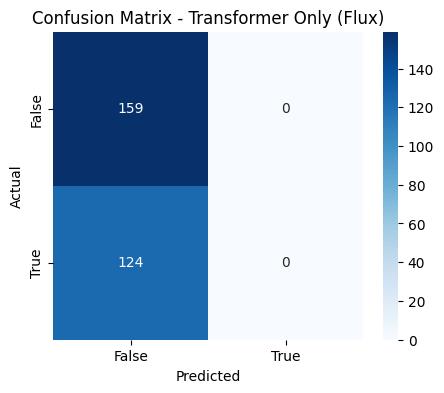

In [23]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

loss, accuracy = model_m2.evaluate(X_seq_test[..., np.newaxis], y_test, verbose=0)
print(f"✅ Transformer-only Test Accuracy: {accuracy:.4f}")

y_pred = (model_m2.predict(X_seq_test[..., np.newaxis]) > 0.5).astype(int)
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["False", "True"], yticklabels=["False", "True"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Transformer Only (Flux)")
plt.show()


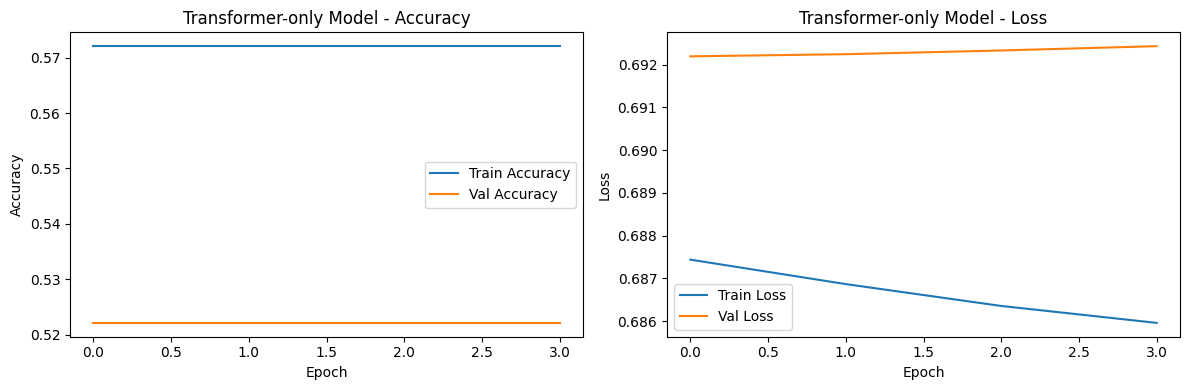

In [24]:
plt.figure(figsize=(12, 4))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history_m2.history['accuracy'], label='Train Accuracy')
plt.plot(history_m2.history['val_accuracy'], label='Val Accuracy')
plt.title('Transformer-only Model - Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history_m2.history['loss'], label='Train Loss')
plt.plot(history_m2.history['val_loss'], label='Val Loss')
plt.title('Transformer-only Model - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


LSTM only for transit data

In [25]:
import tensorflow as tf

def build_lstm_model(seq_shape):
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(seq_shape, 1)),
        tf.keras.layers.LSTM(64, return_sequences=True),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.LSTM(32),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

model_lstm = build_lstm_model(X_seq_train.shape[1])
model_lstm.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 512, 64)           16896     
                                                                 
 dropout_3 (Dropout)         (None, 512, 64)           0         
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dense_9 (Dense)             (None, 32)                1056      
                                                                 
 dense_10 (Dense)            (None, 1)                 33        
                                                                 
Total params: 30401 (118.75 KB)
Trainable params: 30401 (118.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [26]:
history_lstm = model_lstm.fit(
    X_seq_train[..., np.newaxis], y_train,
    validation_split=0.2,
    epochs=20,
    batch_size=32,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)]
)


Epoch 1/20
29/29 [==============================] - 13s 316ms/step - loss: 0.6813 - accuracy: 0.5654 - val_loss: 0.6955 - val_accuracy: 0.5221
Epoch 2/20
29/29 [==============================] - 11s 372ms/step - loss: 0.6738 - accuracy: 0.5721 - val_loss: 0.6931 - val_accuracy: 0.5221
Epoch 3/20
29/29 [==============================] - 10s 358ms/step - loss: 0.6723 - accuracy: 0.5721 - val_loss: 0.6942 - val_accuracy: 0.5221
Epoch 4/20
29/29 [==============================] - 8s 283ms/step - loss: 0.6722 - accuracy: 0.5721 - val_loss: 0.6905 - val_accuracy: 0.5221
Epoch 5/20
29/29 [==============================] - 10s 338ms/step - loss: 0.6736 - accuracy: 0.5721 - val_loss: 0.6885 - val_accuracy: 0.5221
Epoch 6/20
29/29 [==============================] - 10s 348ms/step - loss: 0.6697 - accuracy: 0.5721 - val_loss: 0.6899 - val_accuracy: 0.5221
Epoch 7/20
29/29 [==============================] - 9s 318ms/step - loss: 0.6696 - accuracy: 0.5721 - val_loss: 0.6882 - val_accuracy: 0.5221
E

✅ LSTM-only Test Accuracy: 0.5618
9/9 [==============================] - 1s 72ms/step
              precision    recall  f1-score   support

           0       0.56      1.00      0.72       159
           1       0.00      0.00      0.00       124

    accuracy                           0.56       283
   macro avg       0.28      0.50      0.36       283
weighted avg       0.32      0.56      0.40       283



c:\Users\Roshen Hasangha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Roshen Hasangha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Roshen Hasangha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this beh

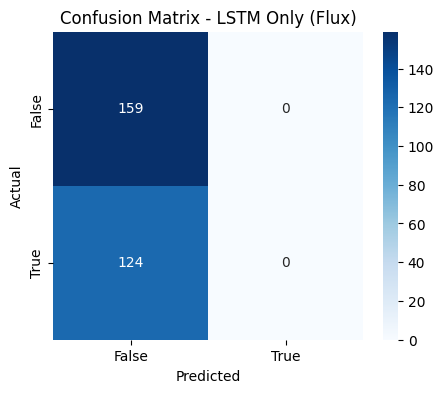

In [27]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

loss, accuracy = model_lstm.evaluate(X_seq_test[..., np.newaxis], y_test, verbose=0)
print(f"✅ LSTM-only Test Accuracy: {accuracy:.4f}")

y_pred = (model_lstm.predict(X_seq_test[..., np.newaxis]) > 0.5).astype(int)
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["False", "True"], yticklabels=["False", "True"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - LSTM Only (Flux)")
plt.show()


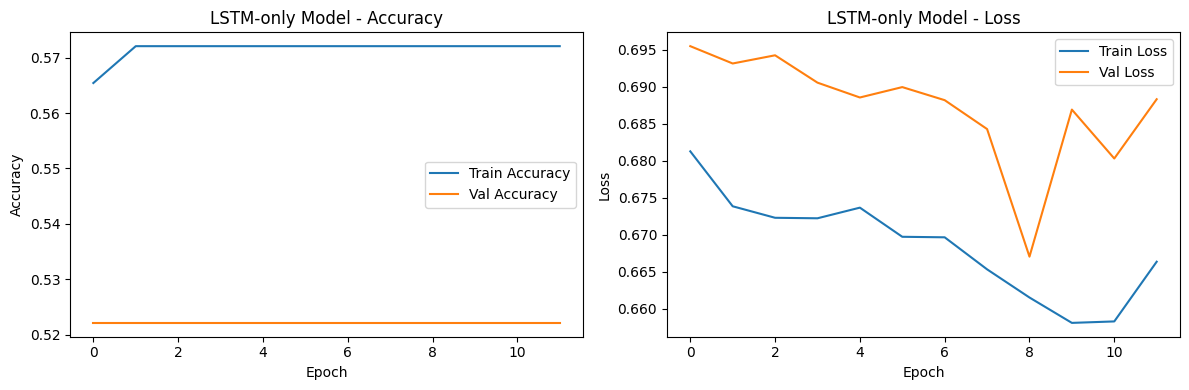

In [28]:
plt.figure(figsize=(12, 4))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history_lstm.history['accuracy'], label='Train Accuracy')
plt.plot(history_lstm.history['val_accuracy'], label='Val Accuracy')
plt.title('LSTM-only Model - Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history_lstm.history['loss'], label='Train Loss')
plt.plot(history_lstm.history['val_loss'], label='Val Loss')
plt.title('LSTM-only Model - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
